# 개요
 * MNIST 데이터셋을 바탕으로 숫자를 인식하는 모델을 만들고, 해당 모델을 바탕으로 웹캠을 이용하여 생성한 손글씨 숫자 이미지들을 예측한다. 

# 1. mnist

* 필요한 라이브러리 먼저 선언.

In [13]:
#!pip install keras==2.6.0

In [1]:
import keras
keras.__version__

'2.6.0'

In [2]:
from keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import numpy as np
import os
import matplotlib.pyplot as plt

* mnist 데이터를 불러온 후, 데이터를 분할.

In [3]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

* 각 데이터를 살펴본다.

In [4]:
print(train_images.shape)
print(test_images.shape)

(60000, 28, 28)
(10000, 28, 28)


In [5]:
print(train_labels.shape)
print(test_labels.shape)

(60000,)
(10000,)


In [7]:
train_labels

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

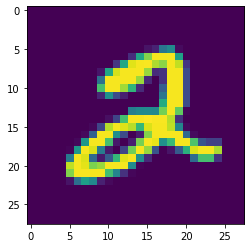

In [19]:
plt.imshow(train_images[5])
plt.show()

* 데이터 전처리 실시.

In [20]:
train_images = train_images.reshape((60000, 28, 28, 1)) 
train_images = train_images.astype('float32') / 255 #normalization

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255
    
train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)

## 2. create model

* 모델 생성을 위한 라이브러리 선언.

In [21]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense

* 모델 생성

In [22]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 576)               0

* 모델 다이어그램

In [24]:
from tensorflow.keras.utils import plot_model

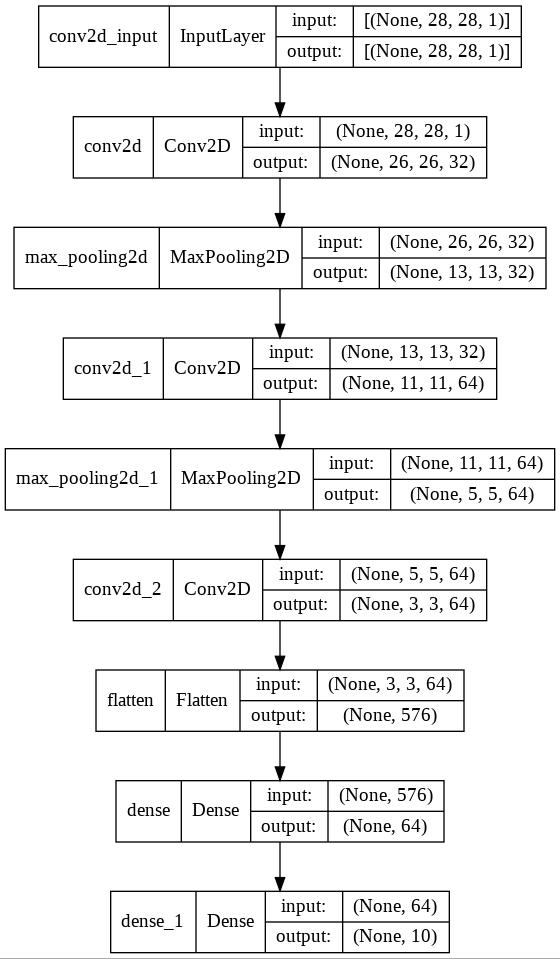

In [25]:
plot_model(model, to_file='model.jpg', show_shapes=True)

* 모델 학습

In [26]:
model.compile(optimizer='rmsprop', 
               loss='categorical_crossentropy',
               metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=50, batch_size=64)

Epoch 1/50
938/938 [==============================] - 11s 9ms/step - loss: 0.1727 - accuracy: 0.9446
Epoch 2/50
938/938 [==============================] - 8s 9ms/step - loss: 0.0465 - accuracy: 0.9859
Epoch 3/50
938/938 [==============================] - 8s 9ms/step - loss: 0.0318 - accuracy: 0.9900
Epoch 4/50
938/938 [==============================] - 8s 9ms/step - loss: 0.0251 - accuracy: 0.9927
Epoch 5/50
938/938 [==============================] - 8s 9ms/step - loss: 0.0196 - accuracy: 0.9940
Epoch 6/50
938/938 [==============================] - 9s 9ms/step - loss: 0.0154 - accuracy: 0.9956
Epoch 7/50
938/938 [==============================] - 9s 9ms/step - loss: 0.0132 - accuracy: 0.9960
Epoch 8/50
938/938 [==============================] - 9s 9ms/step - loss: 0.0106 - accuracy: 0.9968
Epoch 9/50
938/938 [==============================] - 8s 9ms/step - loss: 0.0094 - accuracy: 0.9971
Epoch 10/50
938/938 [==============================] - 9s 9ms/step - loss: 0.0084 - accuracy: 0.997

* 모델 평가

In [27]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

313/313 [==============================] - 2s 5ms/step - loss: 0.1315 - accuracy: 0.9928


## 3. webcam

* 웹캠에서 사진을 인식하는 기능 구현

In [28]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [29]:
#from tensorflow.keras.applications.nasnet import NASNetLarge 
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.nasnet import preprocess_input, decode_predictions

In [30]:
import matplotlib.cm as cm
import tensorflow as tf

* 데이터 예측

<IPython.core.display.Javascript object>

Saved to photo.jpg


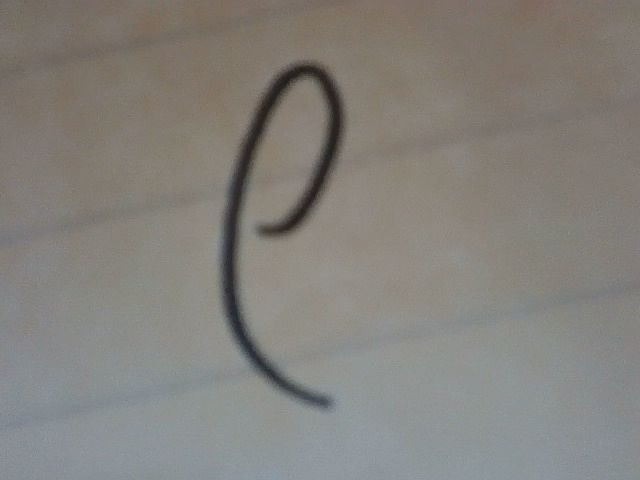

result : [[1.9171246e-11 4.0600759e-01 1.4145611e-01 1.7441580e-03 1.0006582e-02
  2.4866955e-07 9.8949373e-12 4.4078517e-01 8.0849688e-08 9.3598516e-09]]
Max : 0.44078516960144043
Predict : 7


In [402]:
from IPython.display import Image
import PIL.ImageOps 
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))

  img = image.load_img(filename, target_size=(28, 28))
  img_gray = (img.convert('L'))
  img_inverted = PIL.ImageOps.invert(img_gray)
  img_array = image.img_to_array(img_inverted)
  img_array = np.expand_dims(img_array, axis=0)
  img_array = preprocess_input(img_array)


  preds = model.predict(img_array)
  print(f'result : {preds}')
  print(f'Max : {max(preds[0])}')
  print(f'Predict : {list(preds[0]).index(max(preds[0]))}')

except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

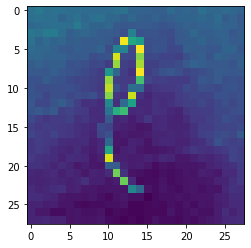

In [403]:
plt.imshow(img_inverted)

# 4. Grad-CAM

* 출처 : https://keras.io/examples/vision/grad_cam/

* 히트맵 생성 함수


In [305]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [404]:
last_conv_layer_name = 'conv2d_2'

In [406]:
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, list(preds[0]).index(max(preds[0])))

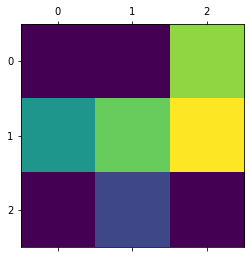

In [407]:
plt.matshow(heatmap)
plt.show()

* 원본 사진과 히트맵을 겹친 이미지

In [63]:
#!pip install opencv-python

In [408]:
import cv2
# cv2 모듈을 사용해 원본 이미지를 로드
img = cv2.imread(filename)

# heatmap을 원본 이미지 크기에 맞게 변경
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# heatmap을 RGB 포맷으로 변환
heatmap = np.uint8(255 * heatmap)

# 히트맵으로 변환
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4는 히트맵의 강도
superimposed_img = heatmap * 0.4 + img

# 디스크에 이미지를 저장
cv2.imwrite('./mnist_cam.jpg', superimposed_img)

True

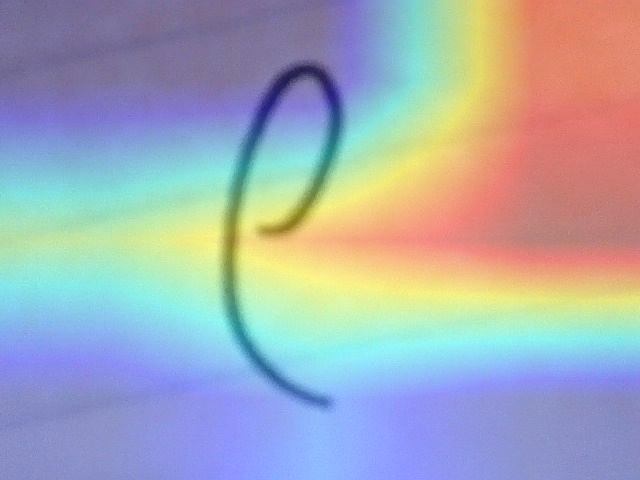

In [409]:
from IPython.display import Image
Image(filename='./mnist_cam.jpg') 